In [1]:
import numpy as np
from matplotlib import pyplot as plt
from utils import CarTrajectoryNonLinear, EKF, plot_trajectory

In [2]:
system = CarTrajectoryNonLinear()
states, measurements = system.get_data()

f = system.f
F_jacobian = system.F_jacobian
h = system.h
H_jacobian = system.H_jacobian
Q = system.Q
R = system.R

In [4]:
extended_kalman_filter = EKF(f, F_jacobian, h, H_jacobian, Q, R, dim_m = 4, dim_y = 2)
state_estimates, cov_estimates = extended_kalman_filter.filter(measurements)
state_estimates_smoothed, cov_estimates_smoothed = extended_kalman_filter.smoother(state_estimates, cov_estimates)

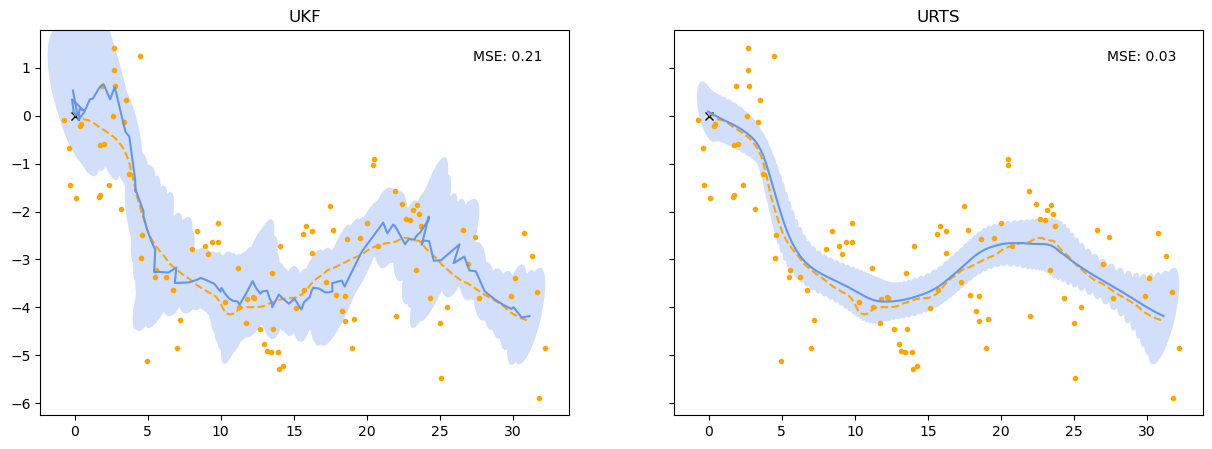

In [10]:
#Compare methods
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
for k in range(2):
    ax[k].plot(states[0, 0], states[0, 1], 'x', color='k', label="Start")
    ax[k].plot(states[:, 0], states[:, 1], '--', color='orange', label="True trajectory")
    ax[k].plot(measurements[:, 0], measurements[:, 1], '.', color='orange', label="Noisy observations")
    
plot_trajectory(ax[0], state_estimates, cov_estimates, label="UKF")
ax[0].set_title("EKF")

plot_trajectory(ax[1], state_estimates_smoothed, cov_estimates_smoothed, label="URTS")
ax[1].set_title("ERTS")

# Show the MSE on the plot in upper right corner
ax[0].text(0.95, 0.95, "MSE: {:.2f}".format(np.mean((states[:, :2] - state_estimates[:, :2])**2)),
           horizontalalignment='right', verticalalignment='top', transform=ax[0].transAxes)
ax[1].text(0.95, 0.95, "MSE: {:.2f}".format(np.mean((states[:, :2] - state_estimates_smoothed[:, :2])**2)),
           horizontalalignment='right', verticalalignment='top', transform=ax[1].transAxes)

plt.show()